In [39]:
import sys

import pandas as pd # type: ignore
import numpy as np # type: ignore

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

import networkx as nx # type: ignore
import graphviz # type: ignore

import statsmodels.formula.api as smf # type: ignore
import statsmodels.api # type: ignore
from statsmodels.miscmodels.ordinal_model import OrderedModel # type: ignore

from dowhy import CausalModel, gcm # type: ignore

from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.neighbors import NearestNeighbors # type: ignore

import warnings
warnings.filterwarnings("ignore")

In [40]:
# Clean data
df = pd.read_csv("../data/processed/data.csv")

In [41]:
# Dealing with missing values for now
df.rename(columns={'Product_price': 'revenue'}, inplace=True) 
df['Product_price'] = df['revenue'] + df['freight_value']
df['Product_weight_kg'] = df['Product_weight_kg'].fillna(df['Product_weight_kg'].mean())
df['distance_km'] = df['distance_km'].fillna(df['distance_km'].mean())
df['Product_size'] = df['Product_size'].fillna(df['Product_size'].mean())
# df['customer_avg_score'] = df['customer_avg_score'].fillna(df['customer_avg_score'].mean())
df['No_photos'] = df['No_photos'].fillna(df['No_photos'].mean())
df['Product_price'] = df['Product_price'].fillna(df['Product_price'].mean())
df['freight_value'] = df['freight_value'].fillna(df['freight_value'].mean())
df['Rating'] = df['Rating'].round()
df['Product_category'] = df['Product_category'].fillna(df['Product_category'].mode()[0])
df['revenue'] = df['revenue'].fillna(df['revenue'].mean())

# Regression 
confounded

In [10]:
formula = 'Rating ~ is_delivery_late'
model = smf.ols(formula=formula, data=df)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                 1.391e+04
Date:                Sat, 05 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:50:38   Log-Likelihood:            -2.0086e+05
No. Observations:              118146   AIC:                         4.017e+05
Df Residuals:                  118144   BIC:                         4.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1328      0.004  

In [12]:
formula = 'Rating ~ late_delivery_in_days'
model = smf.ols(formula=formula, data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     6324.
Date:                Sat, 05 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:50:56   Log-Likelihood:            -1.9418e+05
No. Observations:              114861   AIC:                         3.884e+05
Df Residuals:                  114859   BIC:                         3.884e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.71

In [70]:
# Interpret
model = OrderedModel(df['Rating'], df['is_delivery_late'], distr='logit')
results = model.fit(method='bfgs')
print(results.summary())


Optimization terminated successfully.
         Current function value: 1.193346
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22
                             OrderedModel Results                             
Dep. Variable:                 Rating   Log-Likelihood:            -1.4218e+05
Model:                   OrderedModel   AIC:                         2.844e+05
Method:            Maximum Likelihood   BIC:                         2.844e+05
Date:                Tue, 01 Oct 2024                                         
Time:                        22:31:39                                         
No. Observations:              119143                                         
Df Residuals:                  119138                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

\begin{align*}
    \text{logit}(P(Y \leq 1.0/2.0)) &= -2.1580 - 2.2398x_1 \\
    \text{logit}(P(Y \leq 2.0/3.0)) &= -1.1719 -2.2398x_1
\end{align*}


---
# Effect Inference

### **DoWhy**: Potential Outcomes

In [42]:
# nodes
nodes_list = [
'Rating',
'Product_category_encoded',
'freight_value',
'distance_km',
'season',
'is_delivery_late'
]
# edges
edges_list = [
    ('season', 'Rating'),
    ('season', 'is_delivery_late'),
    ('season', 'Product_category_encoded'),
    ('is_delivery_late', 'Rating'),
    ('Product_category_encoded', 'is_delivery_late'),
    ('Product_category_encoded', 'Rating'),
    ('Product_category_encoded', 'freight_value'),
    ('Product_category_encoded', 'Rating'),
    ('freight_value', 'is_delivery_late'),
    ('freight_value', 'Rating'),
    ('distance_km', 'freight_value'),
    ('distance_km', 'Rating'),
]

# Graph
G = nx.DiGraph()
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)

In [43]:
methods_dict = {
    "Propensity Score Matching": "backdoor.propensity_score_matching",
    "Propensity Score Stratification": "backdoor.propensity_score_stratification",
    "Propensity Score-based Inverse Weighting": "backdoor.propensity_score_weighting",
    "Linear Regression": "backdoor.linear_regression",
    "Generalized Linear Models": "backdoor.generalized_linear_model",
    "Instrumental Variables": "iv.instrumental_variable",
    "Regression Discontinuity": "iv.regression_discontinuity",
    "Two Stage Regression": "frontdoor.two_stage_regression"
}


In [46]:
# Causal Graph params
treatment='is_delivery_late' 
outcome='Rating'

# Estimation params
method_name_estimation = 'backdoor.propensity_score_weighting'
target_units = 'ate'


# Causal Model
model = CausalModel(data=df, graph=G, treatment=treatment, outcome=outcome)
# causal_graph.replace("\n", " ")


# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimation
causal_estimate = model.estimate_effect(identified_estimand, method_name=method_name_estimation, target_units=target_units)
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                  
───────────────────(E[Rating|freight_value,season,Product_category_encoded])
d[is_delivery_late]                                                         
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→Rating then P(Rating|is_delivery_late,freight_value,season,Product_category_encoded,U) = P(Rating|is_delivery_late,freight_value,season,Product_category_encoded)

## Realized estimand
b: Rating~is_delivery_late+freight_value+season+Product_category_encoded
Target units: ate

## Estimate
Mean value: -1.8858906548417136



In [17]:
# Refutation params
method_name='random_common_cause'
placebo_type='permute'

refutation = model.refute_estimate(identified_estimand, causal_estimate, method_name=method_name,
                                           placebo_type=placebo_type, num_simulations=20, show_progress_bar=True) 

print(refutation)

Refuting Estimates:   0%|          | 0/20 [00:00<?, ?it/s]

Refuting Estimates: 100%|██████████| 20/20 [00:01<00:00, 13.25it/s]

Refute: Add a random common cause
Estimated effect:-1.8858906548417136
New effect:-1.8858906548417143
p value:0.15865525393145707



---
---
### Cohort Analysis

In [53]:
df['propensity_score'].describe()['std']

In [55]:
control = df[df['is_delivery_late'] == 0]
treatment = df[df['is_delivery_late'] == 1]
ps_std = df['propensity_score'].describe()['std']
control_match_index_lst = []


for ps in treatment['propensity_score']:
    lower_bound = ps - ps_std
    upper_bound = ps + ps_std
    matched_control = control[(control['propensity_score'] >=  lower_bound) & (control['propensity_score'] <= upper_bound)]

    if matched_control.shape[0] == 0:
        control_match_index_lst.append(np.nan)
    elif matched_control.shape[0] == 1:
        control_match_index_lst.append(matched_control.index)
    else:
        control_match_index_lst.append(matched_control.index[0])
    

In [64]:
temp_df = df['customer_unique_id'].value_counts().reset_index()
temp_df.columns = ['customer_unique_id', 'total_num_orders']
df2 = pd.merge(df, temp_df, how='left', on='customer_unique_id')

control_df = df2.iloc[control_match_index_lst]
treatment_df = df2.iloc[treatment.index]

**Bucket 1, 1 order**

In [73]:
control_avg_rating = control_df[control_df['total_num_orders'] == 1]['Rating'].mean()
treatment_avg_rating = treatment_df[treatment_df['total_num_orders'] == 1]['Rating'].mean()
print(f"ATE Bucket 1: {treatment_avg_rating - control_avg_rating}")

ATE Bucket 1: -2.6556325996357555


**Bucket 2, 2-5 orders**

In [77]:
control_avg_rating = control_df[(control_df['total_num_orders'] > 1) & (control_df['total_num_orders'] <= 5)]['Rating'].mean()
treatment_avg_rating = treatment_df[(treatment_df['total_num_orders'] > 1) & (treatment_df['total_num_orders'] <= 5)]['Rating'].mean()
print(f"ATE Bucket 2: {treatment_avg_rating - control_avg_rating}")


ATE Bucket 2: -2.676467602877932


In [75]:
control_avg_rating = control_df[control_df['total_num_orders'] > 5]['Rating'].mean()
treatment_avg_rating = treatment_df[treatment_df['total_num_orders'] > 5]['Rating'].mean()
print(f"ATE Bucket 1: {treatment_avg_rating - control_avg_rating}")

ATE Bucket 1: -2.071428571428571


In [83]:
df2.select_dtypes(exclude='object').corr()

,payment_value,Rating,Product_weight_kg,distance_km,Product_size,No_photos,revenue,season,is_delivery_late,Product_price.1,...,cips_weight,ips_normalized_weight,tips_normalized_weight,cips_normalized_weight,ips_stabilized_weight,tips_stabilized_weight,cips_stabilized_weight,d_y,dbar_y,total_num_orders
payment_value,1.000000,-0.082343,0.301450,0.089288,0.269831,0.009962,0.734817,0.005225,0.008753,0.739236,...,-0.005107,-0.002920,0.029687,-0.005100,0.032359,0.251192,-0.067431,-0.006646,-0.060967,0.089125
Rating,-0.082343,1.000000,-0.028272,-0.052663,-0.028600,0.021837,-0.004444,0.025587,-0.324518,-0.004492,...,-0.313857,-0.314978,-0.324395,-0.313866,0.024524,-0.010818,0.030994,-0.095185,0.909113,-0.063508
Product_weight_kg,0.301450,-0.028272,1.000000,-0.007630,0.803462,0.021362,0.339221,-0.011653,0.025438,0.339221,...,0.001618,0.005148,0.057537,0.001632,0.038807,0.385677,-0.115232,0.002969,-0.015627,0.026149
distance_km,0.089288,-0.052663,-0.007630,1.000000,-0.009533,0.014451,0.085696,-0.002188,0.074836,0.085696,...,0.055955,0.058227,0.090637,0.055967,-0.008933,0.192190,-0.087952,0.036192,-0.057462,-0.021453
Product_size,0.269831,-0.028600,0.803462,-0.009533,1.000000,0.010378,0.298603,-0.002509,0.020678,0.298603,...,-0.001723,0.001782,0.053897,-0.001711,0.049968,0.398914,-0.108573,-0.000236,-0.013566,0.033105
No_photos,0.009962,0.021837,0.021362,0.014451,0.010378,1.000000,0.052373,0.010724,-0.002991,0.052373,...,-0.002673,-0.002704,-0.003106,-0.002673,0.000712,-0.001490,0.001375,-0.000129,0.019171,-0.033801
revenue,0.734817,-0.004444,0.339221,0.085696,0.298603,0.052373,1.000000,0.000308,0.022183,1.000000,...,0.005784,0.008302,0.045578,0.005793,0.032909,0.281228,-0.079045,0.001552,0.004023,-0.040910
season,0.005225,0.025587,-0.011653,-0.002188,-0.002509,0.010724,0.000308,1.000000,-0.029665,0.000309,...,0.012868,0.008239,-0.060675,0.012844,0.050793,-0.372785,0.206737,0.015750,0.010518,0.008057
is_delivery_late,0.008753,-0.324518,0.025438,0.074836,0.020678,-0.002991,0.022183,-0.029665,1.000000,0.022188,...,0.979023,0.981555,0.996513,0.979046,-0.039531,-0.004364,-0.040911,0.794684,-0.619200,-0.024487
Product_price.1,0.739236,-0.004492,0.339221,0.085696,0.298603,0.052373,1.000000,0.000309,0.022188,1.000000,...,0.005785,0.008304,0.045592,0.005794,0.032914,0.281550,-0.079045,0.001554,0.004064,-0.040994


In [81]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  119143 non-null  object 
 1   customer_id               119143 non-null  object 
 2   customer_unique_id        119143 non-null  object 
 3   payment_value             119140 non-null  float64
 4   Rating                    118146 non-null  float64
 5   region                    119143 non-null  object 
 6   Product_weight_kg         119143 non-null  float64
 7   distance_km               119143 non-null  float64
 8   Product_category          119143 non-null  object 
 9   Product_size              119143 non-null  float64
 10  No_photos                 119143 non-null  float64
 11  revenue                   119143 non-null  float64
 12  season                    119143 non-null  int64  
 13  is_delivery_late          119143 non-null  i

# Treatment as a continuous variable

<Axes: ylabel='Frequency'>

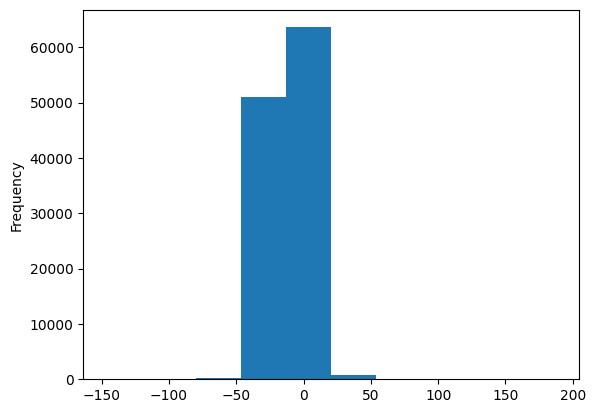

In [16]:
df['late_delivery_in_days'].plot(kind='hist')

In [33]:
# nodes
nodes_list = [
'Rating',
'Product_category_encoded',
'freight_value',
'distance_km',
'season',
'late_delivery_in_days'
]
# edges
edges_list = [
    ('season', 'Rating'),
    ('season', 'late_delivery_in_days'),
    ('season', 'Product_category_encoded'),
    ('late_delivery_in_days', 'Rating'),
    ('Product_category_encoded', 'late_delivery_in_days'),
    ('Product_category_encoded', 'Rating'),
    ('Product_category_encoded', 'freight_value'),
    ('Product_category_encoded', 'Rating'),
    ('freight_value', 'late_delivery_in_days'),
    ('freight_value', 'Rating'),
    ('distance_km', 'freight_value'),
    ('distance_km', 'Rating'),
]

# Graph
G = nx.DiGraph()
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)

In [34]:
temp_df = df[nodes_list]
temp_df.dropna(inplace=True)

# Causal Graph params
treatment='late_delivery_in_days' 
outcome='Rating'

# Estimation params
method_name_estimation = 'backdoor.linear_regression'
target_units = 'ate'

# Causal Model
model = CausalModel(data=temp_df, graph=G, treatment=treatment, outcome=outcome)

# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimation
causal_estimate = model.estimate_effect(identified_estimand, method_name=method_name_estimation, target_units=target_units)
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                   ↪
────────────────────────(E[Rating|season,freight_value,Product_category_encode ↪
d[late_delivery_in_days]                                                       ↪

↪    
↪ d])
↪    
Estimand assumption 1, Unconfoundedness: If U→{late_delivery_in_days} and U→Rating then P(Rating|late_delivery_in_days,season,freight_value,Product_category_encoded,U) = P(Rating|late_delivery_in_days,season,freight_value,Product_category_encoded)

## Realized estimand
b: Rating~late_delivery_in_days+season+freight_value+Product_category_encoded
Target units: ate

## Estimate
Mean value: -0.03088960638993088



# Treatment as bins

In [38]:
df['late_delivery_in_days'].describe().T

count    115722.000000
mean        -12.048392
std          10.163801
min        -147.000000
25%         -17.000000
50%         -13.000000
75%          -7.000000
max         188.000000
Name: late_delivery_in_days, dtype: float64

---
There're 7559 late deliveries, when the deliveries are late, they're late on average by 10 days

---

In [50]:
late_df = df[df['late_delivery_in_days'] > 0]
on_time_df = df[df['late_delivery_in_days'] <= 0]
late_df['late_delivery_in_days'].describe()

count    7559.000000
mean       10.573489
std        14.632885
min         1.000000
25%         3.000000
50%         7.000000
75%        13.000000
max       188.000000
Name: late_delivery_in_days, dtype: float64

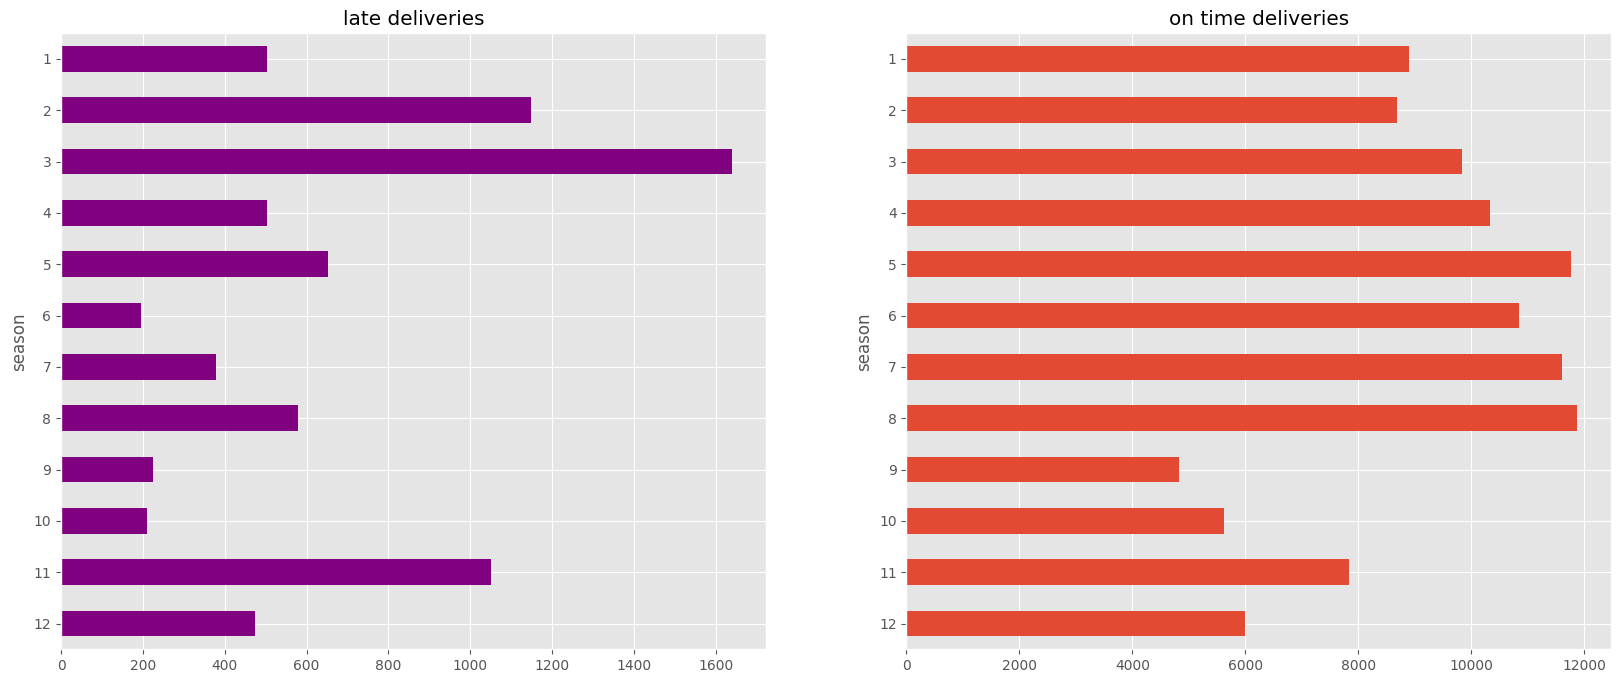

In [58]:
plt.style.use("ggplot")
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
late_df['season'].value_counts().sort_index(ascending=False).plot(kind='barh', title='late deliveries', color='purple', ax=ax[0])
on_time_df['season'].value_counts().sort_index(ascending=False).plot(kind='barh', title='on time deliveries', ax=ax[1])
plt.show()

In [101]:
# Creating Bins
df.loc[(df['late_delivery_in_days'] > 0) & (df['late_delivery_in_days'] <= 4), 'late_bin'] = 'late_1_4_days'
df.loc[(df['late_delivery_in_days'] > 5) & (df['late_delivery_in_days'] <= 10), 'late_bin'] = 'late_5_10_days'
df.loc[(df['late_delivery_in_days'] > 10), 'late_bin'] = 'late_10_plus_days'

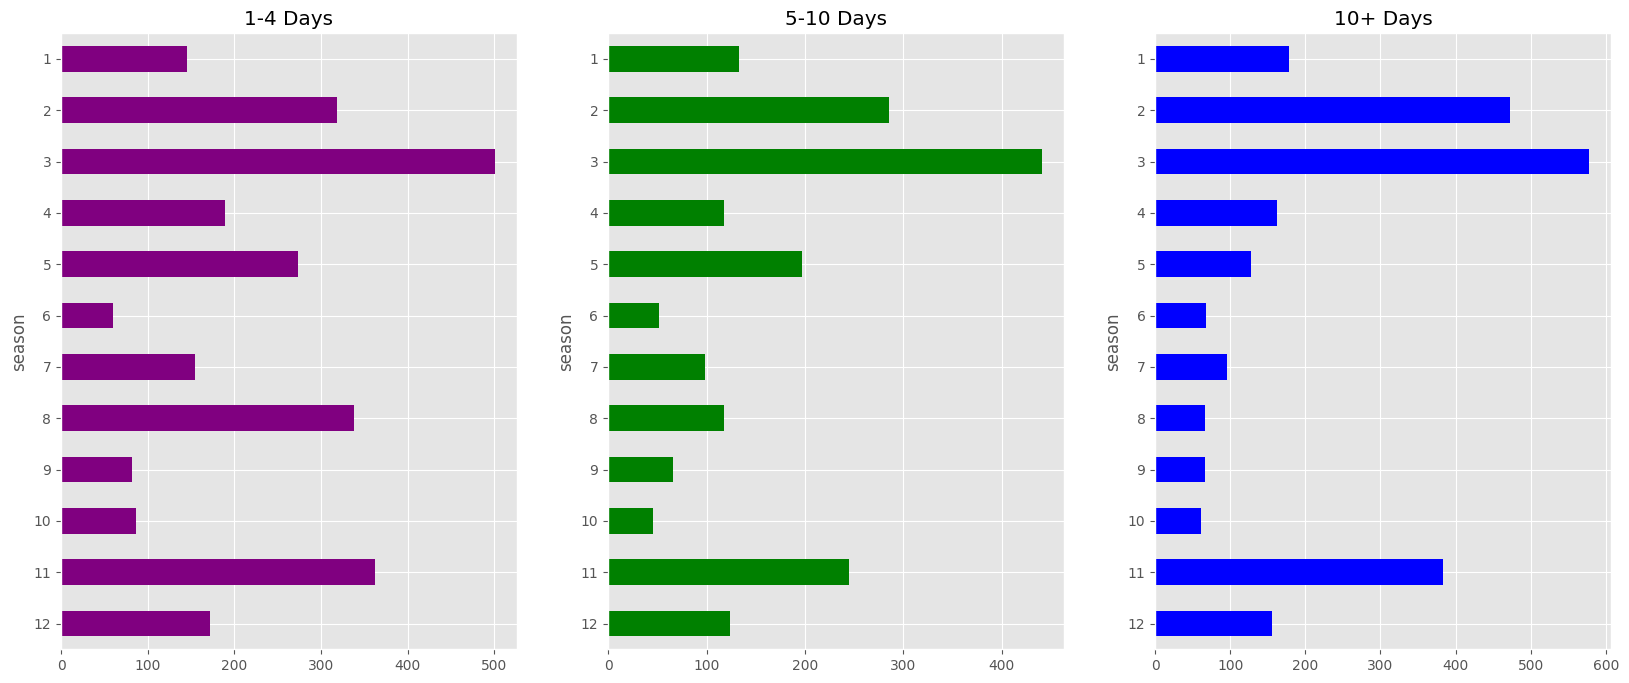

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
df[df['late_bin'] == 'late_1_4_days']['season'].value_counts().sort_index(ascending=False).plot(kind='barh',
                                                                                                 title='1-4 Days', 
                                                                                                 color='purple',
                                                                                                 ax=ax[0])


df[df['late_bin'] == 'late_5_10_days']['season'].value_counts().sort_index(ascending=False).plot(kind='barh',
                                                                                                 title='5-10 Days', 
                                                                                                 color='green',
                                                                                                 ax=ax[1])

df[df['late_bin'] == 'late_10_plus_days']['season'].value_counts().sort_index(ascending=False).plot(kind='barh',
                                                                                                 title='10+ Days', 
                                                                                                 color='blue',
                                                                                                 ax=ax[2])
plt.show()


In [102]:
# nodes
nodes_list = [
'Rating',
'Product_category_encoded',
'freight_value',
'distance_km',
'season',
'late_bin_num'
]
# edges
edges_list = [
    ('season', 'Rating'),
    ('season', 'late_bin_num'),
    ('season', 'Product_category_encoded'),
    ('late_bin_num', 'Rating'),
    ('Product_category_encoded', 'late_bin_num'),
    ('Product_category_encoded', 'Rating'),
    ('Product_category_encoded', 'freight_value'),
    ('Product_category_encoded', 'Rating'),
    ('freight_value', 'late_bin_num'),
    ('freight_value', 'Rating'),
    ('distance_km', 'freight_value'),
    ('distance_km', 'Rating'),
]

# Graph
G = nx.DiGraph()
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)


# ----- model

df.loc[df['late_bin'] == 'late_1_4_days', 'late_bin_num'] = 1
df.loc[df['late_bin'] == 'late_5_10_days', 'late_bin_num'] = 2
df.loc[df['late_bin'] == 'late_10_plus_days', 'late_bin_num'] = 3

temp_df = df[nodes_list]
temp_df.dropna(inplace=True)

# Causal Graph params
treatment='late_bin_num' 
outcome='Rating'

# Estimation params
method_name_estimation = 'backdoor.linear_regression'
target_units = 'ate'

# Causal Model
model = CausalModel(data=temp_df, graph=G, treatment=treatment, outcome=outcome)

# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimation
causal_estimate = model.estimate_effect(identified_estimand, method_name=method_name_estimation, target_units=target_units)
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                
───────────────(E[Rating|season,freight_value,Product_category_encoded])
d[late_bin_num]                                                         
Estimand assumption 1, Unconfoundedness: If U→{late_bin_num} and U→Rating then P(Rating|late_bin_num,season,freight_value,Product_category_encoded,U) = P(Rating|late_bin_num,season,freight_value,Product_category_encoded)

## Realized estimand
b: Rating~late_bin_num+season+freight_value+Product_category_encoded
Target units: ate

## Estimate
Mean value: -0.6972778730693143



In [97]:
temp_df

,Rating,Product_category_encoded,freight_value,distance_km,season,late_bin
40,3.0,40,38.20,1528.696471,1,late_1_4_days
75,4.0,21,33.17,408.507994,12,late_5_10_days
86,4.0,40,32.11,412.013510,7,late_1_4_days
106,3.0,40,31.36,392.189505,4,late_10_plus_days
119,1.0,40,39.93,1089.919485,3,late_10_plus_days
...,...,...,...,...,...,...
118237,1.0,72,19.32,918.660910,3,late_1_4_days
118254,1.0,72,78.09,97.188574,5,late_5_10_days
118278,1.0,72,26.63,720.780045,3,late_5_10_days
118283,4.0,54,26.20,581.471922,1,late_1_4_days


In [88]:
temp_df.loc[temp_df['late_bin'] == 'late_1_4_days', 'late_bin_num'] = 1
temp_df.loc[temp_df['late_bin'] == 'late_5_10_days', 'late_bin_num'] = 2
temp_df.loc[temp_df['late_bin'] == 'late_10_plus_days', 'late_bin_num'] = 3

,Rating,Product_category_encoded,freight_value,distance_km,season,late_bin
40,3.0,40,38.20,1528.696471,1,late_1_4_days
75,4.0,21,33.17,408.507994,12,late_5_10_days
86,4.0,40,32.11,412.013510,7,late_1_4_days
106,3.0,40,31.36,392.189505,4,late_10_plus_days
119,1.0,40,39.93,1089.919485,3,late_10_plus_days
...,...,...,...,...,...,...
118237,1.0,72,19.32,918.660910,3,late_1_4_days
118254,1.0,72,78.09,97.188574,5,late_5_10_days
118278,1.0,72,26.63,720.780045,3,late_5_10_days
118283,4.0,54,26.20,581.471922,1,late_1_4_days
